In [1]:
# Cell 1: imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import random
%matplotlib inline


In [11]:
import os
print("Current working directory:")
os.chdir("..")
print(os.getcwd())



Current working directory:
c:\Ansh\glucose-forecast-project


In [12]:
import os

os.chdir(r"C:\Ansh\glucose-forecast-project")  # or adjust as explained above
print("Now working from:", os.getcwd())

DATA_DIR = "data/archive"
print("Path exists:", os.path.exists(DATA_DIR))
print("Sample files:", os.listdir(DATA_DIR)[:10])


Now working from: C:\Ansh\glucose-forecast-project
Path exists: True
Sample files: ['559-ws-testing.xml', '559-ws-training.xml', '563-ws-testing.xml', '563-ws-training.xml', '570-ws-testing.xml', '570-ws-training.xml', '575-ws-testing.xml', '575-ws-training.xml', '588-ws-testing.xml', '588-ws-training.xml']


In [13]:
import xml.etree.ElementTree as ET
import pandas as pd
from tqdm import tqdm

def parse_ohio_xml(filepath):
    """
    Parse a single OhioT1DM XML file and extract glucose measurements.
    """
    try:
        tree = ET.parse(filepath)
        root = tree.getroot()
    except Exception as e:
        print("Error parsing", filepath, ":", e)
        return pd.DataFrame()

    records = []
    for elem in root.iter():
        ts = elem.attrib.get('ts') or elem.attrib.get('time') or elem.attrib.get('timestamp')
        val = elem.attrib.get('value') or elem.attrib.get('glucose') or elem.attrib.get('sgv')
        if ts and val:
            try:
                records.append({'timestamp': pd.to_datetime(ts), 'glucose': float(val)})
            except Exception:
                pass

    if not records:
        return pd.DataFrame()
    df = pd.DataFrame(records)
    df = df.sort_values('timestamp').drop_duplicates().reset_index(drop=True)
    return df


In [14]:
all_dfs = []
for fname in tqdm(os.listdir(DATA_DIR)):
    if fname.endswith(".xml"):
        fpath = os.path.join(DATA_DIR, fname)
        df0 = parse_ohio_xml(fpath)
        if not df0.empty:
            df0["patient"] = fname.replace(".xml", "")
            all_dfs.append(df0)

print(f"Parsed {len(all_dfs)} XML files.")
if all_dfs:
    df_all = pd.concat(all_dfs, ignore_index=True)
    print("Combined dataframe shape:", df_all.shape)
    display(df_all.head())


  0%|          | 0/12 [00:00<?, ?it/s]C:\Users\acer\AppData\Local\Temp\ipykernel_9428\651039279.py:22: UserWarning: Parsing dates in %d-%m-%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  records.append({'timestamp': pd.to_datetime(ts), 'glucose': float(val)})
  8%|▊         | 1/12 [00:21<03:52, 21.18s/it]C:\Users\acer\AppData\Local\Temp\ipykernel_9428\651039279.py:22: UserWarning: Parsing dates in %d-%m-%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  records.append({'timestamp': pd.to_datetime(ts), 'glucose': float(val)})
 17%|█▋        | 2/12 [01:33<08:30, 51.09s/it]C:\Users\acer\AppData\Local\Temp\ipykernel_9428\651039279.py:22: UserWarning: Parsing dates in %d-%m-%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  records.appen

Parsed 12 XML files.
Combined dataframe shape: (536042, 3)


,timestamp,glucose,patient
0,2022-01-18 00:00:00,89.600000,559-ws-testing
1,2022-01-18 00:00:00,57.000000,559-ws-testing
2,2022-01-18 00:00:00,92.300000,559-ws-testing
3,2022-01-18 00:01:00,0.000183,559-ws-testing
4,2022-01-18 00:01:00,179.000000,559-ws-testing


In [16]:
import os
import pandas as pd

rows = []
for pid, g in df_all.groupby("patient"):
    g = g.set_index("timestamp").resample("5min").mean(numeric_only=True)
    g["glucose"] = g["glucose"].interpolate()
    g = g.reset_index()
    g["patient"] = pid
    rows.append(g)

df_clean = pd.concat(rows, ignore_index=True)
os.makedirs("data", exist_ok=True)
df_clean.to_csv("data/ohio_cgm_combined.csv", index=False)

print("Saved to data/ohio_cgm_combined.csv")
df_clean.head()


Saved to data/ohio_cgm_combined.csv


,timestamp,glucose,patient
0,2022-01-18 00:00:00,69.650030,559-ws-testing
1,2022-01-18 00:05:00,70.316697,559-ws-testing
2,2022-01-18 00:10:00,70.983363,559-ws-testing
3,2022-01-18 00:15:00,71.483362,559-ws-testing
4,2022-01-18 00:20:00,72.150028,559-ws-testing


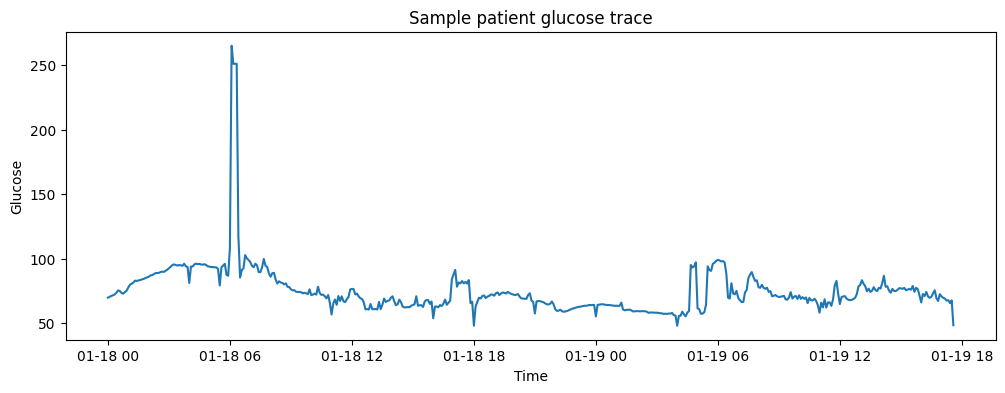

In [17]:
import matplotlib.pyplot as plt

sample = df_clean[df_clean["patient"] == df_clean["patient"].unique()[0]].iloc[:500]
plt.figure(figsize=(12,4))
plt.plot(sample["timestamp"], sample["glucose"])
plt.title("Sample patient glucose trace")
plt.xlabel("Time")
plt.ylabel("Glucose")
plt.show()


In [18]:
# CELL 2 — smoothing, sort, ensure timestamps
df_clean = df_clean.sort_values(["patient", "timestamp"]).reset_index(drop=True)

# create a smoothed column if not present
if "glucose_smooth" not in df_clean.columns:
    df_clean["glucose_smooth"] = df_clean["glucose"].rolling(window=3, min_periods=1).mean()

# check for gaps / NaNs
print("Total rows:", len(df_clean))
print("NaNs per column:\n", df_clean.isna().sum())


Total rows: 961506
NaNs per column:
 timestamp         0
glucose           0
patient           0
glucose_smooth    0
dtype: int64


In [19]:
# CELL 3 — create lag features and horizon target per patient
n_lags = 12          # last 12 readings -> 60 minutes if freq=5min
horizon = 6          # 6 steps ahead -> 30 minutes

def create_features_for_patient(g):
    g = g.sort_values("timestamp").copy()
    # ensure consistent freq if not already: assume it's resampled before
    for lag in range(1, n_lags+1):
        g[f"lag_{lag}"] = g["glucose_smooth"].shift(lag)
    g[f"target_h{horizon}"] = g["glucose_smooth"].shift(-horizon)
    return g

df = df_clean.groupby("patient", group_keys=False).apply(create_features_for_patient)
# drop rows with NaN (beginning/ending of each patient where lags/targets missing)
df = df.dropna().reset_index(drop=True)
print("After feature creation shape:", df.shape)
df[[ "patient", "timestamp", "glucose_smooth", "lag_1", "lag_2", f"target_h{horizon}" ]].head(8)


C:\Users\acer\AppData\Local\Temp\ipykernel_9428\3337238821.py:13: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df_clean.groupby("patient", group_keys=False).apply(create_features_for_patient)


After feature creation shape: (961290, 17)


,patient,timestamp,glucose_smooth,lag_1,lag_2,target_h6
0,559-ws-testing,2022-01-18 01:00:00,75.458923,73.892244,73.318905,82.800488
1,559-ws-testing,2022-01-18 01:05:00,77.380057,75.458923,73.892244,82.967326
2,559-ws-testing,2022-01-18 01:10:00,79.185653,77.380057,75.458923,83.356473
3,559-ws-testing,2022-01-18 01:15:00,80.462388,79.185653,77.380057,83.745709
4,559-ws-testing,2022-01-18 01:20:00,81.522491,80.462388,79.185653,84.246133
5,559-ws-testing,2022-01-18 01:25:00,82.244820,81.522491,80.462388,84.746657
6,559-ws-testing,2022-01-18 01:30:00,82.800488,82.244820,81.522491,85.302829
7,559-ws-testing,2022-01-18 01:35:00,82.967326,82.800488,82.244820,85.970288


In [20]:
# # keep time order: use early part to train, last 20% to test
# split_idx = int(len(df)*0.8)
# train_df = df.iloc[:split_idx].copy()
# test_df  = df.iloc[split_idx:].copy()

# features = [f'lag_{i}' for i in range(1, n_lags+1)]
# X_train, y_train = train_df[features].values, train_df[f'target_h{horizon}'].values
# X_test, y_test = test_df[features].values, test_df[f'target_h{horizon}'].values

# print("Train size:", X_train.shape, "Test size:", X_test.shape)

# CELL 4 — time-based 80/20 per patient
train_rows = []
test_rows = []

for pid, g in df.groupby("patient"):
    g = g.sort_values("timestamp").reset_index(drop=True)
    split_idx = int(len(g) * 0.8)
    if split_idx < 1:
        # skip tiny patients
        continue
    train_rows.append(g.iloc[:split_idx])
    test_rows.append(g.iloc[split_idx:])

train_df = pd.concat(train_rows, ignore_index=True)
test_df  = pd.concat(test_rows, ignore_index=True)

features = [f"lag_{i}" for i in range(1, n_lags+1)]
target_col = f"target_h{horizon}"

print("Train shape:", train_df.shape, "Test shape:", test_df.shape)
print("Feature vector example shape:", len(features))



Train shape: (769026, 17) Test shape: (192264, 17)
Feature vector example shape: 12


RandomForest MAE: 1.241  RMSE: 7.311


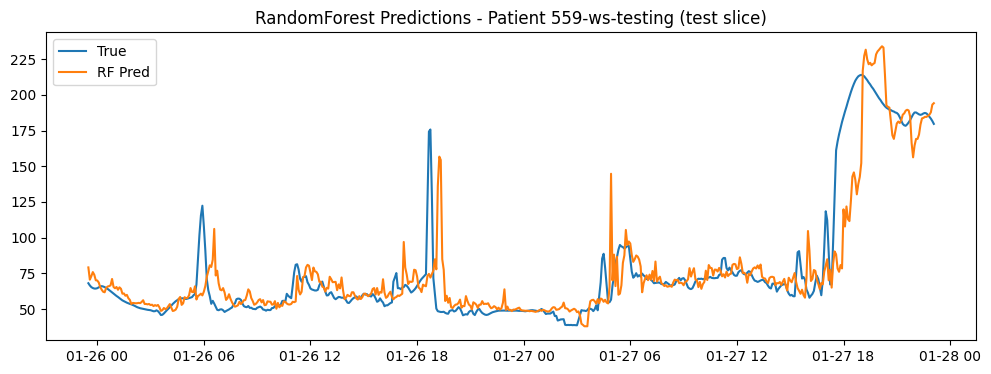

In [22]:
# CELL 5 — RandomForest baseline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

X_train = train_df[features].values
y_train = train_df[target_col].values
X_test  = test_df[features].values
y_test  = test_df[target_col].values

rf = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)

mae_rf = mean_absolute_error(y_test, pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, pred_rf))  # changed line
print(f"RandomForest MAE: {mae_rf:.3f}  RMSE: {rmse_rf:.3f}")

# Plot a sample contiguous segment from test set for visualization (by patient)
sample_pid = test_df['patient'].iloc[0]
sample_mask = test_df['patient'] == sample_pid
ts = test_df.loc[sample_mask, 'timestamp']
plt.figure(figsize=(12,4))
plt.plot(ts, test_df.loc[sample_mask, target_col].values, label='True')
plt.plot(ts, pred_rf[sample_mask.values], label='RF Pred')
plt.title(f"RandomForest Predictions - Patient {sample_pid} (test slice)")
plt.legend(); plt.show()


In [23]:
# CELL 6 — prepare PyTorch dataset: sequences shaped (seq_len, 1)
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

class SequenceDataset(Dataset):
    def __init__(self, df, features, target_col):
        self.X = df[features].values.astype(np.float32)   # shape (N, seq_len)
        self.y = df[target_col].values.astype(np.float32) # shape (N,)
        self.seq_len = self.X.shape[1]
    def __len__(self): return len(self.y)
    def __getitem__(self, idx):
        x = self.X[idx].reshape(self.seq_len, 1)  # (seq_len, features=1)
        y = np.array([self.y[idx]], dtype=np.float32)
        return torch.from_numpy(x), torch.from_numpy(y)

train_ds = SequenceDataset(train_df, features, target_col)
test_ds  = SequenceDataset(test_df, features, target_col)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=64, shuffle=False)

print("Train batches:", len(train_loader), "Test batches:", len(test_loader))


Train batches: 12017 Test batches: 3005


In [24]:
# CELL 7 — define LSTM model
import torch.nn as nn
import torch

class SimpleLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=1, out_size=1, dropout=0.0):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc   = nn.Linear(hidden_size, out_size)
    def forward(self, x):
        # x: (batch, seq_len, features)
        out, _ = self.lstm(x)             # out: (batch, seq_len, hidden)
        last = out[:, -1, :]              # last timestep
        out = self.fc(last)               # (batch, out_size)
        return out

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleLSTM(input_size=1, hidden_size=64, num_layers=1).to(device)
print(model)


SimpleLSTM(
  (lstm): LSTM(1, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


In [26]:
# CELL 8 — training loop (fixed for older sklearn)
import torch.optim as optim
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

epochs = 20
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

for epoch in range(1, epochs+1):
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    # quick eval on test loader
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            out = model(xb).cpu().numpy().squeeze()
            preds.append(out)
            trues.append(yb.numpy().squeeze())

    preds = np.concatenate(preds)
    trues = np.concatenate(trues)
    mae = mean_absolute_error(trues, preds)
    rmse = np.sqrt(mean_squared_error(trues, preds))  # fixed line ✅

    if epoch % 2 == 0 or epoch == 1:
        print(f"Epoch {epoch}/{epochs}  train_loss={np.mean(train_losses):.5f}  test_MAE={mae:.4f}  test_RMSE={rmse:.4f}")


Epoch 1/20  train_loss=33.98139  test_MAE=2.0121  test_RMSE=7.7971
Epoch 2/20  train_loss=32.84134  test_MAE=1.9255  test_RMSE=7.5811
Epoch 4/20  train_loss=31.46465  test_MAE=1.3329  test_RMSE=7.5284
Epoch 6/20  train_loss=34.86186  test_MAE=1.4037  test_RMSE=7.9162
Epoch 8/20  train_loss=31.89079  test_MAE=3.2482  test_RMSE=7.8017
Epoch 10/20  train_loss=31.61953  test_MAE=1.6566  test_RMSE=7.4540
Epoch 12/20  train_loss=30.95040  test_MAE=1.8852  test_RMSE=7.7293
Epoch 14/20  train_loss=30.77745  test_MAE=1.7138  test_RMSE=7.4478
Epoch 16/20  train_loss=30.55329  test_MAE=1.4830  test_RMSE=7.4675
Epoch 18/20  train_loss=30.28539  test_MAE=1.5138  test_RMSE=7.4079
Epoch 20/20  train_loss=30.26709  test_MAE=1.3550  test_RMSE=7.6170


✅ Saved LSTM to models/lstm_cgm.pth
Final LSTM MAE: 1.3550435304641724
Final LSTM RMSE: 7.616977160557403


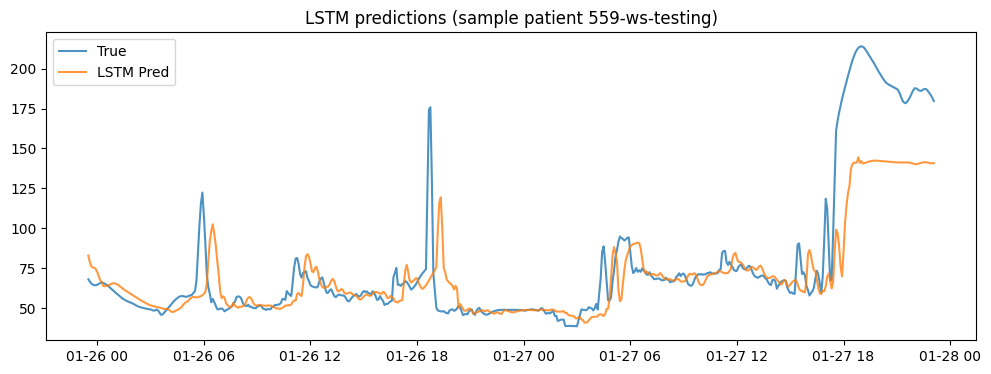

In [28]:
# CELL 9 — final metrics, plot sample and save model (fixed for old sklearn)
import os, matplotlib.pyplot as plt, numpy as np
os.makedirs("models", exist_ok=True)
torch.save(model.state_dict(), "models/lstm_cgm.pth")
print("✅ Saved LSTM to models/lstm_cgm.pth")

# compute final preds on test set
model.eval()
preds = []
trues = []
timestamps = []

with torch.no_grad():
    for i, (xb, yb) in enumerate(test_loader):
        xb = xb.to(device)
        out = model(xb).cpu().numpy().squeeze()
        preds.append(out)
        trues.append(yb.numpy().squeeze())

preds = np.concatenate(preds)
trues = np.concatenate(trues)

print("Final LSTM MAE:", mean_absolute_error(trues, preds))
print("Final LSTM RMSE:", np.sqrt(mean_squared_error(trues, preds)))  # ✅ fixed line

# plot a random patient's contiguous slice from test_df for comparison
sample_pid = test_df['patient'].unique()[0]
mask = (test_df['patient'] == sample_pid)
ts = test_df.loc[mask, 'timestamp'].values

plt.figure(figsize=(12,4))
plt.plot(ts, test_df.loc[mask, target_col].values, label='True', alpha=0.8)

# Need to align preds indices — here we plot first len(ts) predictions if shapes match:
plot_preds = preds[:mask.sum()] if len(preds) >= mask.sum() else preds
plt.plot(ts[:len(plot_preds)], plot_preds, label='LSTM Pred', alpha=0.8)
plt.title(f"LSTM predictions (sample patient {sample_pid})")
plt.legend()
plt.show()


In [ ]:
import os
import pandas as pd

rows = []
for pid, g in df_all.groupby("patient"):
    g = g.set_index("timestamp").resample("5min").mean(numeric_only=True)
    g["glucose"] = g["glucose"].interpolate()
    g = g.reset_index()
    g["patient"] = pid
    rows.append(g)

df_clean = pd.concat(rows, ignore_index=True)
os.makedirs("data", exist_ok=True)
df_clean.to_csv("data/ohio_cgm_combined.csv", index=False)

print("Saved to data/ohio_cgm_combined.csv")
df_clean.head()


Saved to data/ohio_cgm_combined.csv


,timestamp,glucose,patient
0,2022-01-18 00:00:00,69.650030,559-ws-testing
1,2022-01-18 00:05:00,70.316697,559-ws-testing
2,2022-01-18 00:10:00,70.983363,559-ws-testing
3,2022-01-18 00:15:00,71.483362,559-ws-testing
4,2022-01-18 00:20:00,72.150028,559-ws-testing
